# Concatenation, Analysis

In [147]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [148]:
class KLDiv:
    """KL-Divergence over measured computational basis probabilities"""

    def __call__(self, channel, input, target):
        N = target.shape[0]
        d = channel.spam.d
        U_prep, U_basis = input
        
        state = tf.repeat(tf.expand_dims(channel.spam.init.init, axis=0), N, axis=0)
        state = apply_unitary(state, U_prep)
        state = channel.apply_channel(state)
        
        mask = tf.math.real(target) > 1e-15

        output = measurement(state, U_basis, channel.spam.povm.povm)
        loss = tf.math.reduce_sum(target[mask] * tf.math.log(target[mask] / output[mask]))

        return loss

def evaluate_channel(channel, inputs, targets):
    d = channel.d
    kl_div = KLDiv()
    loss = kl_div(channel, inputs, targets)
    return np.real(loss)


def calculate_channel_fittness(filename, num_layers = None):
    model_list = loader(data_path(filename + "_fitted.model"))
    reps = len(model_list)//3
    
    d = model_list[0].channel.d
    n = int(np.log2(d))

    U1_circuit_list = []
    U2_circuit_list = []
    U3_circuit_list = []

    R1_fid_list = []
    R2_fid_list = []
    R3_fid_list = []

    U1_fid_list = []
    U2_fid_list = []
    U3_fid_list = []

    T1_fid_list = []
    T2_fid_list = []
    T12_fid_list = []
    T3_fid_list = []

    np.random.seed(42)
    random.seed(42)
    
    for i in tqdm(range(reps)):

        circuit1 = pqc_basic(n, num_layers)#.reverse_bits()
        U1 = circuit_to_matrix(circuit1)
        U1_circuit_list.append(U1)

        circuit2 = pqc_basic(n, num_layers)#.reverse_bits()
        U2 = circuit_to_matrix(circuit2)
        U2_circuit_list.append(U2)

        circuit3 = deepcopy(circuit1)
        circuit3 = circuit3.compose(circuit2)
        U3 = circuit_to_matrix(circuit3)
        U3_circuit_list.append(U3)

        #Throw-away computation to advance RNG correctly
        circuit_target_list = [circuit1, circuit2, circuit3]
        belem_concatenate = ExecuteAndCollect()
        belem_concatenate.setup_circuits(circuit_target_list, N_map = 2000-6**n)
    
    for i in range(reps):
        inputs1, targets1, _, _ = loader(data_path(filename + f"{i}0"))
        inputs2, targets2, _, _ = loader(data_path(filename + f"{i}1"))
        inputs3, targets3, _, _ = loader(data_path(filename + f"{i}2"))
        

        model1 = model_list[3*i]
        model2 = model_list[3*i+1]
        model3 = model_list[3*i+2]

        channel1 = model1.channel
        channel2 = model2.channel
        channel3 = model3.channel

        channel12 = channel_to_choi_map([channel1, channel2])
        channel12.spam = channel3.spam

        identity_channel1 = IdentityChannel(d)
        identity_channel1.spam = channel1.spam

        identity_channel2 = IdentityChannel(d)
        identity_channel2.spam = channel2.spam

        identity_channel3 = IdentityChannel(d)
        identity_channel3.spam = channel3.spam

        U_channel1 = ChoiMapStatic(U1_circuit_list[i], mode="unitary")
        U_channel1.spam = channel1.spam

        U_channel2 = ChoiMapStatic(U2_circuit_list[i], mode="unitary")
        U_channel2.spam = channel2.spam

        U_channel3 = ChoiMapStatic(U3_circuit_list[i], mode="unitary")
        U_channel3.spam = channel3.spam

        R1_fid_list.append(evaluate_channel(identity_channel1, inputs1, targets1))
        R2_fid_list.append(evaluate_channel(identity_channel2, inputs2, targets2))
        R3_fid_list.append(evaluate_channel(identity_channel3, inputs3, targets3)) 

        U1_fid_list.append(evaluate_channel(U_channel1, inputs1, targets1))
        U2_fid_list.append(evaluate_channel(U_channel2, inputs2, targets2))
        U3_fid_list.append(evaluate_channel(U_channel3, inputs3, targets3))

        T1_fid_list.append(evaluate_channel(channel1, inputs1, targets1))
        T2_fid_list.append(evaluate_channel(channel2, inputs2, targets2))
        T12_fid_list.append(evaluate_channel(channel12, inputs3, targets3))
        T3_fid_list.append(evaluate_channel(channel3, inputs3, targets3))
        
    
    Id_single_fid_mean = np.mean(R1_fid_list + R2_fid_list)
    Id_single_fid_std= np.std(R1_fid_list + R2_fid_list)
    
    Id_full_fid_mean = np.mean(R3_fid_list)  
    Id_full_fid_std = np.std(R3_fid_list)  

    U_single_fid_mean = np.mean(U1_fid_list + U2_fid_list)
    U_single_fid_std = np.std(U1_fid_list + U2_fid_list)
    
    U_full_fid_mean = np.mean(U3_fid_list)  
    U_full_fid_std = np.std(U3_fid_list)  
    
    T_single_fid_mean = np.mean(T1_fid_list + T2_fid_list)
    T_single_fid_std = np.std(T1_fid_list + T2_fid_list)
    
    T_concat_fid_mean = np.mean(T12_fid_list)
    T_concat_fid_std = np.std(T12_fid_list)
    
    T_full_fid_mean = np.mean(T3_fid_list)
    T_full_fid_std = np.std(T3_fid_list)
    
    mean_list = [Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean]
    std_list = [Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std]

    
    return mean_list, std_list

## KL Divergence with Respect to Real Data

In [159]:
model_list = loader(data_path("belem_concatenate_6layer" + "_fitted.model"))

In [149]:
mean_list1, std_list1 = calculate_channel_fittness(filename= "belem_concatenate_2layer", num_layers = 2)

  0%|          | 0/10 [00:00<?, ?it/s]

In [150]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list1
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list1

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 2016.592 +-168.855
Id Full KL-Div: 1989.502 +-177.696
----
U Single KL-Div: 233.536 +-17.473
U Full KL-Div: 262.730 +-17.632
----
T Single KL-Div: 23.8231 +-10.3535
T Full KL-Div: 17.4136 +-1.3437
T Concat KL-Div: 83.490 +-9.589


In [155]:
mean_list2, std_list2 = calculate_channel_fittness(filename= "belem_concatenate_4layer", num_layers = 4)

  0%|          | 0/10 [00:00<?, ?it/s]

In [156]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list2
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list2

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1998.552 +-130.628
Id Full KL-Div: 1897.574 +-106.138
----
U Single KL-Div: 267.611 +-35.120
U Full KL-Div: 298.363 +-18.299
----
T Single KL-Div: 22.5148 +-16.5160
T Full KL-Div: 14.3748 +-1.0214
T Concat KL-Div: 80.166 +-31.857


In [228]:
mean_list3, std_list3 = calculate_channel_fittness(filename= "belem_concatenate_6layer_retry", num_layers = 6)

  0%|          | 0/10 [00:00<?, ?it/s]

In [229]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list3
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list3

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1725.944 +-80.289
Id Full KL-Div: 1651.091 +-90.725
----
U Single KL-Div: 373.676 +-39.533
U Full KL-Div: 482.734 +-38.316
----
T Single KL-Div: 15.2493 +-14.3475
T Full KL-Div: 7.2190 +-1.3723
T Concat KL-Div: 25.899 +-5.109


In [153]:
mean_list4, std_list4 = calculate_channel_fittness(filename= "belem_concatenate_8layer", num_layers = 8)

  0%|          | 0/10 [00:00<?, ?it/s]

In [233]:
Id_single_fid_mean, Id_full_fid_mean, U_single_fid_mean, U_full_fid_mean, T_single_fid_mean, T_full_fid_mean, T_concat_fid_mean = mean_list4
Id_single_fid_std, Id_full_fid_std, U_single_fid_std, U_full_fid_std, T_single_fid_std, T_full_fid_std, T_concat_fid_std = std_list4

print(f"Id Single KL-Div: {Id_single_fid_mean:.3f} +-{Id_single_fid_std:.3f}")
print(f"Id Full KL-Div: {Id_full_fid_mean:.3f} +-{Id_full_fid_std:.3f}")
print("----")
print(f"U Single KL-Div: {U_single_fid_mean:.3f} +-{U_single_fid_std:.3f}")
print(f"U Full KL-Div: {U_full_fid_mean:.3f} +-{U_full_fid_std:.3f}")
print("----")
print(f"T Single KL-Div: {T_single_fid_mean:.4f} +-{T_single_fid_std:.4f}")
print(f"T Full KL-Div: {T_full_fid_mean:.4f} +-{T_full_fid_std:.4f}")
print(f"T Concat KL-Div: {T_concat_fid_mean:.3f} +-{T_concat_fid_std:.3f}")

Id Single KL-Div: 1769.848 +-78.832
Id Full KL-Div: 1636.700 +-82.812
----
U Single KL-Div: 291.258 +-22.874
U Full KL-Div: 392.798 +-36.592
----
T Single KL-Div: 7.6176 +-7.6773
T Full KL-Div: 7.1346 +-18.3162
T Concat KL-Div: 41.161 +-19.604


In [231]:
mean_list = np.array([mean_list1, mean_list2, mean_list3, mean_list4])
std_list = np.array([std_list1, std_list2, std_list3, std_list4])

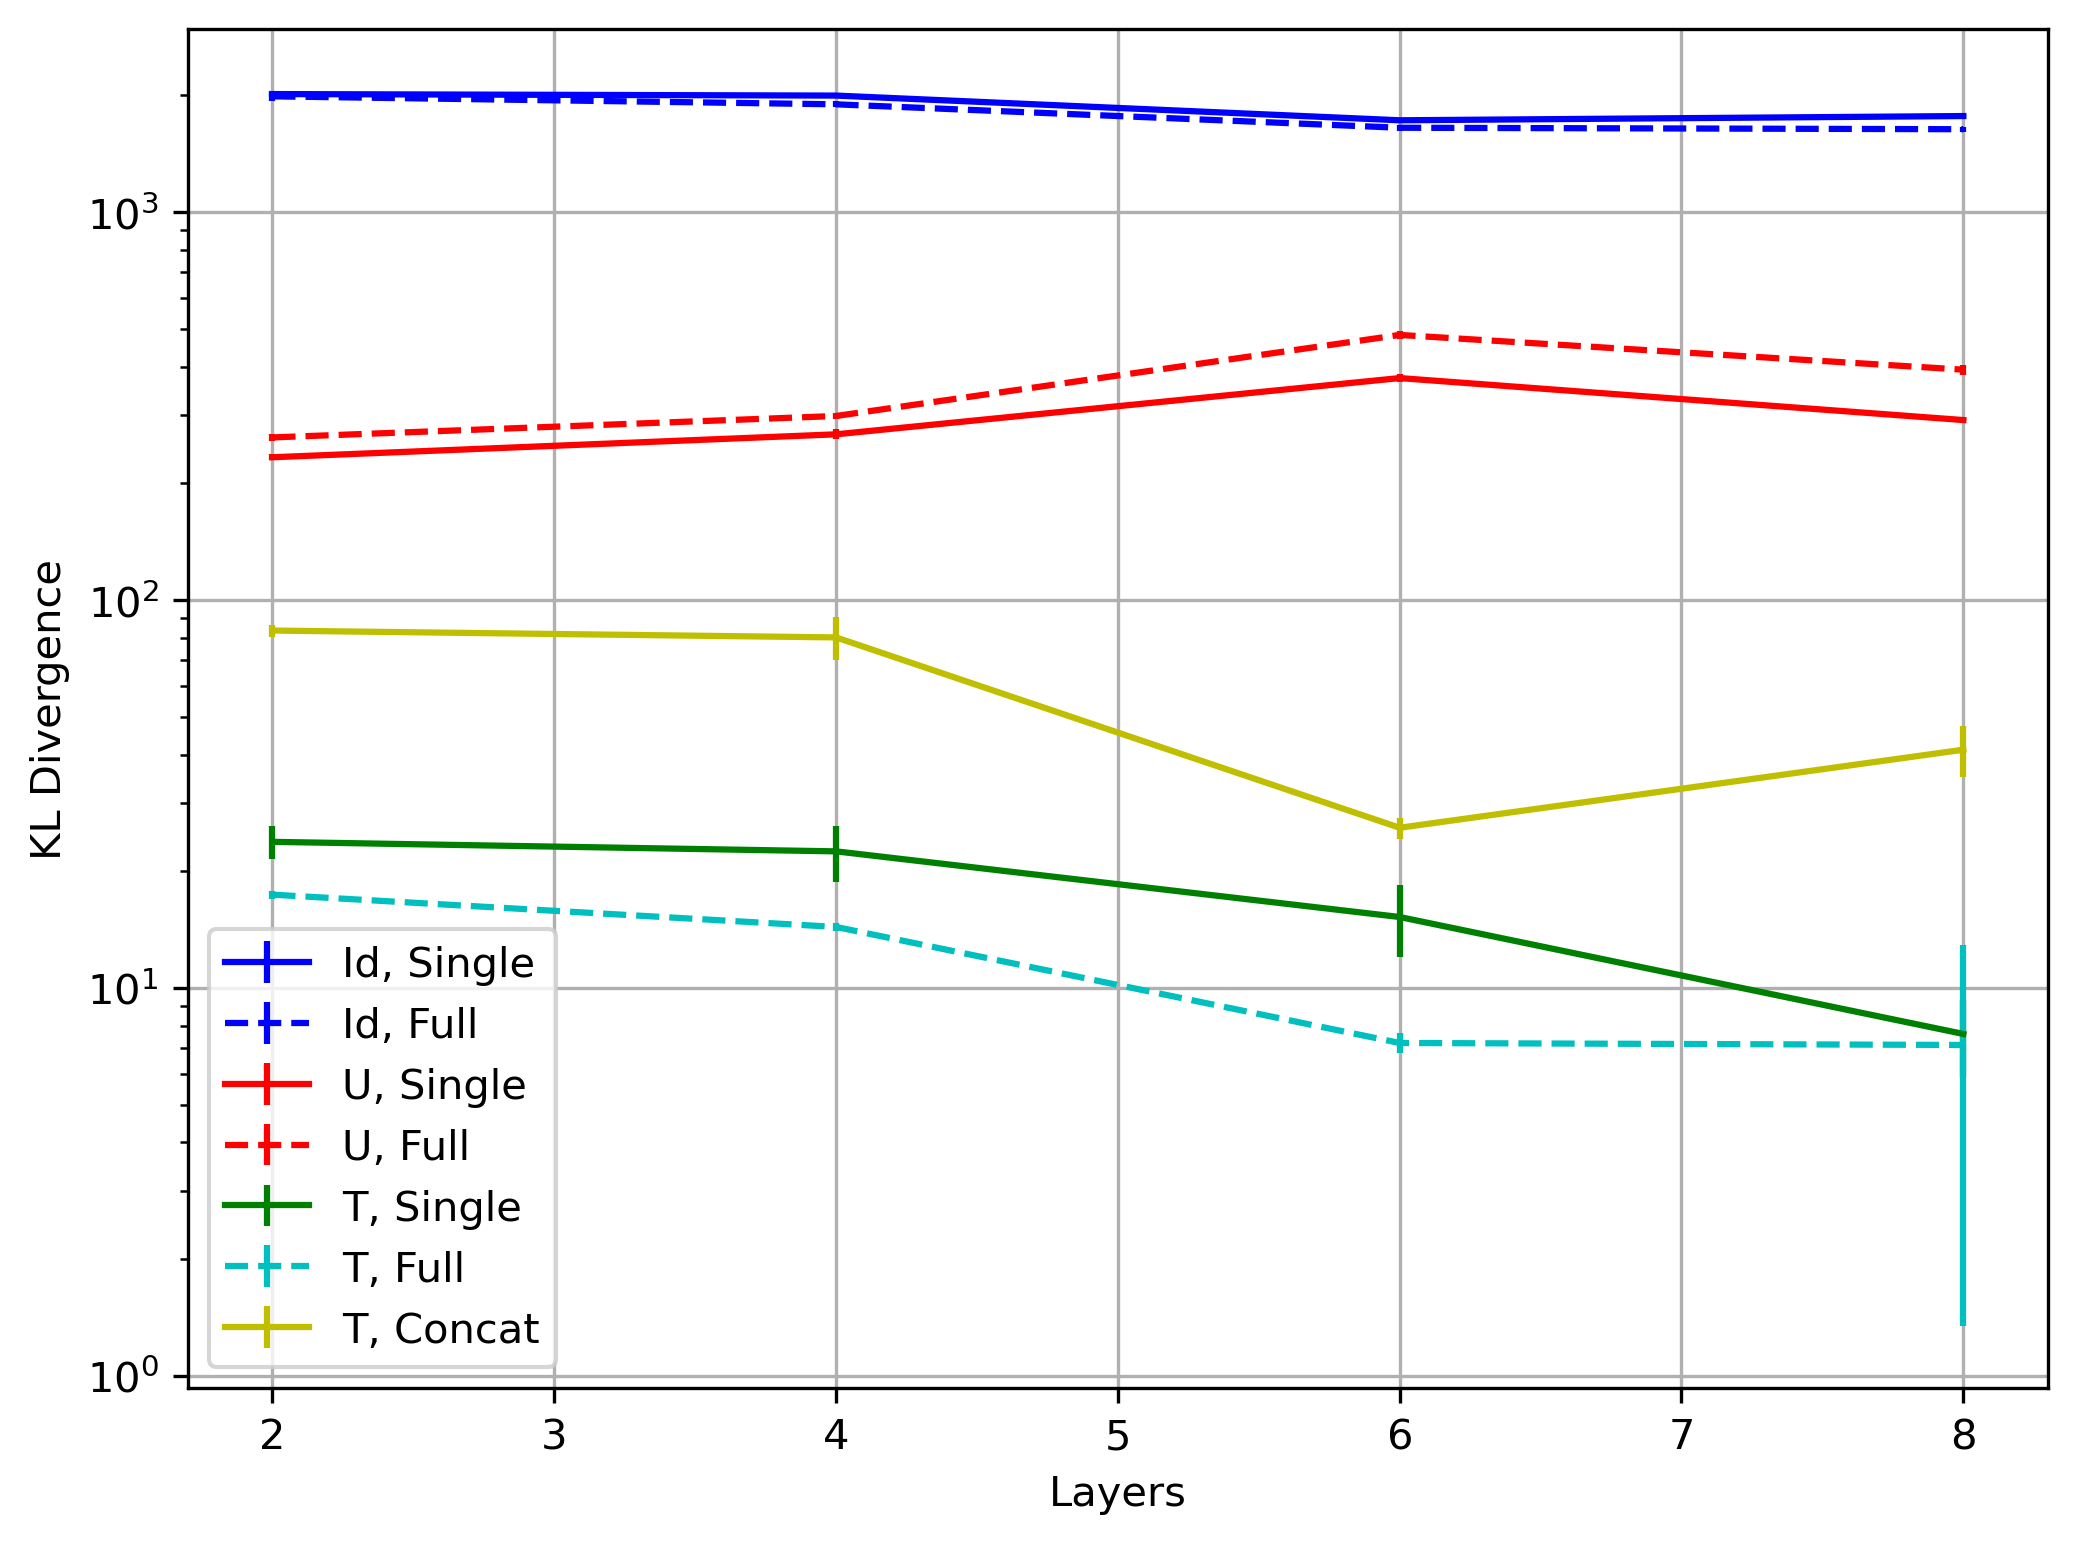

In [236]:
x = [2, 4, 6, 8]
fig = plt.figure(figsize=(8,6), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, mean_list[:,0], yerr = std_list[:,0]/np.sqrt(20), fmt = "b-")
plt.errorbar(x, mean_list[:,1], yerr = std_list[:,1]/np.sqrt(10), fmt = "b--")
plt.errorbar(x, mean_list[:,2], yerr = std_list[:,2]/np.sqrt(20), fmt = "r-")
plt.errorbar(x, mean_list[:,3], yerr = std_list[:,3]/np.sqrt(10), fmt = "r--")
plt.errorbar(x, mean_list[:,4], yerr = std_list[:,4]/np.sqrt(20), fmt = "g-")
plt.errorbar(x, mean_list[:,5], yerr = std_list[:,5]/np.sqrt(10), fmt = "c--")
plt.errorbar(x, mean_list[:,6], yerr = std_list[:,6]/np.sqrt(10), fmt = "y")
plt.legend(["Id, Single", "Id, Full", "U, Single", "U, Full", "T, Single", "T, Full", "T, Concat"])
plt.yscale("log")
plt.xlabel("Layers")
plt.ylabel("KL Divergence")
plt.grid()
plt.show()

In [226]:
filename = "belem_concatenate_6layer_retry"
i = 1
inputs1, targets1, _, _ = loader(data_path(filename + f"{i}0"))
inputs2, targets2, _, _ = loader(data_path(filename + f"{i}1"))
inputs, targets, _, _ = loader(data_path(filename + f"{i}2"))

In [227]:
model_list = loader(data_path(filename + "_fitted.model"))
channel = model_list[3*i+2].channel

N = targets.shape[0]
d = channel.spam.d
U_prep, U_basis = inputs

state = tf.repeat(tf.expand_dims(channel.spam.init.init, axis=0), N, axis=0)
state = apply_unitary(state, U_prep)
state = channel.apply_channel(state)
output = measurement(state, U_basis, channel.spam.povm.povm)
print(output)

mask = tf.math.real(targets) > 1e-15
loss = tf.math.reduce_sum(targets[mask] * tf.math.log(targets[mask] / output[mask]))
print(loss)

tf.Tensor((-2.5201697617684777+3.433730757846998e-15j), shape=(), dtype=complex128)


In [180]:
print(tf.math.reduce_sum(output, axis=1))

tf.Tensor(
[1.+1.2143e-17j 1.+4.3368e-19j 1.-1.9082e-17j ... 1.+8.6736e-18j
 1.+1.2143e-17j 1.-2.6021e-18j], shape=(1784,), dtype=complex128)


In [181]:
print(tf.math.reduce_sum(channel.spam.povm.povm, axis=0))

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(8, 8), dtype=complex128)


In [141]:
print(tf.math.reduce_sum(povm_ideal(8), axis=0))

tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(8, 8), dtype=complex128)


In [145]:
H = 0
n = 6
np.random.seed(44)
gamma = np.random.normal(0,1,n-1)
#gamma = np.zeros(n-1) - 1
I = np.array([[1,0], [0,1]])
X = np.array([[0,1], [1,0]])
XX = np.kron(X,X)

H = 0
for i in range(n-1):
    h = None
    if i != 0:
        h = I
   
    for j in range(i-1):
        h = np.kron(h, I)
   
    if h is None:
        h = XX
    else:
        h = np.kron(h, XX)
   
    for j in range(i+2, n):
        h = np.kron(h, I)
    H += gamma[i]*h

In [146]:
print(np.linalg.eig(H)[0])

[ 6.3862 -6.3862  6.3862 -6.3862  4.8849  4.8849 -4.8849 -4.8849  3.8939
  3.8939  3.7535  3.7535  3.4499  3.4499  3.1763 -3.7535 -3.8939 -3.8939
 -3.7535  3.1763 -3.4499 -3.4499 -3.1763 -3.1763  2.3927  2.3927  2.2522
  2.2522 -2.3927 -2.3927 -2.2522  1.9487  1.9487  1.6751  1.6751 -2.2522
 -1.9487 -1.9487 -1.6751 -1.6751  1.2612  1.2612  0.9576  0.9576  0.6841
  0.8172  0.8172  0.6841  0.5436  0.5436  0.2401  0.2401 -1.2612 -1.2612
 -0.2401 -0.2401 -0.9576 -0.9576 -0.5436 -0.5436 -0.8172 -0.8172 -0.6841
 -0.6841]
